# Deep IRL

Easy game formalism :

- States = (x, t)
- Action = (&uarr;, &darr;, &rarr;, &larr;)
- Reward = r(x)

In [315]:
import numpy as np
import matplotlib.pyplot as plt
import IPython
FLOAT_MAX = 1e30

In [2]:
# Gridworld provides a basic environment for RL agents to interact with

class GridWorld:
    """
    Grid world environment
    """
    
    def __init__(self, length_max, height, width, start_pos):
        """
            input: 
            height - idx : height of the spatial grid
            width - idx : width of the spatial grid
            length - idx : temporal length of a trip
            
            start_pos 2-tuple : coordinates within the state_space (height x width)
            
        """
        self.height = height
        self.width = width
        self.length_max = length_max
        
        self.start = (0, start_pos[0], start_pos[1])
        self.end = (length_max-1, start_pos[0], start_pos[1])
        
        self.n_states = self.height*self.width*self.length_max
        
        self.actions = [0, 1, 2, 3, 4, 5, 6, 7, 8]
        self.n_actions = len(self.actions)
        self.neighbors = [(0, 0),(-1, 0),(-1, 1),(0, 1),(1, 1),(1, 0),(1, -1),(0, -1),(-1, -1)]
        self.dirs = {0: 'stay', 1: 'n', 2: 'ne', 3: 'e', 4: 'se', 5: 's', 6: 'sw', 7: 'w', 8: 'nw'}
    
    def get_grid_idx(self):
        return np.array(range(self.n_states)).reshape((self.length_max, self.height, self.width))
    
    def get_list_state(self):
        return [(i,j,k) for i in range(self.length_max) for j in range(self.height) for k in range(self.width)]
    
    def state2idx(self, state):
        """
        input:
          2d state
        returns:
          1d index
        """
        return self.get_grid_idx()[state]

    def idx2state(self, idx):
        """
        input:
          1d idx
        returns:
          2d state
        """
        return self.get_list_state()[idx]
           
    def get_next_state(self, state, action):
        """
        get next state with [action] on [state]
        args
          state     (z, y, x)
          action    int
        returns
          new state
        """
        if state[0] >= self.length_max-1:
            return state
        else :
            inc = self.neighbors[action]
            nei_s = (state[1] + inc[0], state[2] + inc[1])
            if nei_s[0] >= 0 and nei_s[0] < self.height and nei_s[1] >= 0 and nei_s[1] < self.width:
                next_state = (state[0] + 1, nei_s[0], nei_s[1])
            else:
                next_state = (state[0] + 1, state[1], state[2])
            return next_state

    def get_list_previous_state(self, state):
        """
        args
          state     (z, y, x)
        returns
          tuple
              - previous state (z, y, x)
              - associated action int
        """
        previous = []
        for a in self.actions:
            inc = self.neighbors[a]
            nei_s = (state[1] - inc[0], state[2] - inc[1])

            if nei_s[0] >= 0 and nei_s[0] < self.height and nei_s[1] >= 0 and nei_s[1] < self.width:
                previous_state = (state[0] - 1, nei_s[0], nei_s[1])
                previous.append((previous_state,a))
        return previous

    def get_transition_mat(self):
        """
        get transition dynamics of the gridworld
        return:
          P_a         NxNxN_ACTIONS transition probabilities matrix - 
                        P_a[s0, s1, a] is the transition prob of 
                        landing at state s1 when taking action 
                        a at state s0
        """
        P_a = np.zeros((self.n_states, self.n_states, self.n_actions))
        
        for i in range(self.n_states):
            si = self.idx2state(i)
            for a in range(self.n_actions):
                sj = self.get_next_state(si,a)
                j = self.state2idx(sj)
                P_a[i, j, a] = 1                
        return P_a

In [3]:
g = GridWorld(5,3,4,(1,1))

In [4]:
g.get_grid_idx()

array([[[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11]],

       [[12, 13, 14, 15],
        [16, 17, 18, 19],
        [20, 21, 22, 23]],

       [[24, 25, 26, 27],
        [28, 29, 30, 31],
        [32, 33, 34, 35]],

       [[36, 37, 38, 39],
        [40, 41, 42, 43],
        [44, 45, 46, 47]],

       [[48, 49, 50, 51],
        [52, 53, 54, 55],
        [56, 57, 58, 59]]])

In [5]:
def value_iteration(P_a, rewards, error=0.01, max_iter=100):
    """
    static value iteration function. Perhaps the most useful function in this repo

    inputs:
    P_a         NxNxN_ACTIONS transition probabilities matrix - 
                          P_a[s0, s1, a] is the transition prob of 
                          landing at state s1 when taking action 
                          a at state s0
    rewards     Nx1 matrix - rewards for all the states
    gamma       float - RL discount
    error       float - threshold for a stop

    returns:
    values    Nx1 matrix - estimated values
    policy    Nx1 matrix - policy
    """
    N_STATES, _, N_ACTIONS = np.shape(P_a)
    n = 0 
    values = np.ones([N_STATES])* -FLOAT_MAX
    qvalues = np.ones((N_STATES, N_ACTIONS))* -FLOAT_MAX
    policy = np.zeros((N_STATES, N_ACTIONS))
        
    # estimate values
    while True:
        values_tmp = values.copy()
        values[g.state2idx(g.end)] = 0 # goal
        
        for s in range(N_STATES):
            qvalues[s] = [sum([P_a[s, s1, a]*(rewards[s] + values[s1]) for s1 in range(N_STATES)]) for a in range(N_ACTIONS)]
            
            softmax = max(qvalues[s]) + np.log(1.0 + np.exp(min(qvalues[s]) - max(qvalues[s]))) 
            values[s] = rewards[s] + softmax
            
            policy[s,:] = np.exp(qvalues[s]-values[s])/sum(np.exp(qvalues[s]-values[s]))
            
        if max([abs(values[s] - values_tmp[s]) for s in range(N_STATES)]) < error:
            break
        n += 1
        # max iteration
        if n > max_iter:
            print("    WARNING: max number of iterations", max_iter)
            break    
    
    return values, policy

In [6]:
P = g.get_transition_mat()
R = -np.random.random((g.n_states, 1))

values, policy = value_iteration(P, R, 0.01, 100)

values.reshape((g.length_max, g.height, g.width))

array([[[-1.12589580e+00, -1.92243484e+00, -1.81022541e+00,
         -1.04579154e+00],
        [-2.63316394e+00, -7.02862612e-01, -9.81680963e-01,
         -3.24363688e-01],
        [-9.68738154e-01, -1.61891634e+00, -1.39873132e+00,
         -8.32239973e-01]],

       [[-2.32487325e+00, -9.18048749e-01, -1.36775978e-01,
         -8.35731708e-01],
        [-1.87140384e+00, -1.99541656e+00, -5.04602628e-01,
         -5.31323382e-01],
        [-1.15654903e+00, -1.67337113e+00, -1.35916901e+00,
         -3.19609598e-01]],

       [[-1.01302230e+00, -1.74232833e+00, -6.74015729e-01,
         -1.23571213e+00],
        [-1.13588841e+00, -1.03985182e+00, -7.14470928e-01,
         -2.52812311e-01],
        [-1.36610431e+00, -2.70308991e-01, -1.29095044e+00,
         -5.82370265e-01]],

       [[-5.55909288e-01, -1.30380188e+00, -1.79641239e+00,
         -1.00000000e+30],
        [-1.86817174e+00, -7.56399123e-02, -1.74911770e-01,
         -1.00000000e+30],
        [-6.64946905e-02, -8.36464552

In [7]:
policy

array([[0.0766463 , 0.0766463 , 0.0766463 , 0.31294448, 0.10655465,
        0.12062309, 0.0766463 , 0.0766463 , 0.0766463 ],
       [0.1153785 , 0.1153785 , 0.1153785 , 0.25201555, 0.17445453,
        0.03928529, 0.04447214, 0.02825848, 0.1153785 ],
       [0.15439166, 0.15439166, 0.15439166, 0.07674874, 0.10405767,
        0.10687565, 0.02406725, 0.07068404, 0.15439166],
       [0.09293669, 0.09293669, 0.09293669, 0.09293669, 0.09293669,
        0.12600566, 0.12941802, 0.18695618, 0.09293669],
       [0.08790374, 0.05585578, 0.22805742, 0.0776514 , 0.10715486,
        0.17966557, 0.08790374, 0.08790374, 0.08790374],
       [0.04499018, 0.13213341, 0.28861246, 0.19978827, 0.08500345,
        0.06208408, 0.10409582, 0.05093025, 0.03236209],
       [0.14363027, 0.20748708, 0.10314269, 0.13984318, 0.17281738,
        0.06111003, 0.04463302, 0.032344  , 0.09499234],
       [0.11209334, 0.08267552, 0.11209334, 0.11209334, 0.11209334,
        0.13852429, 0.04898363, 0.11512893, 0.16631429],


In [8]:
def compute_state_visition_freq(P_a, start_idx, nb_step, policy):
    """compute the expected states visition frequency p(s| theta, T) 
    using dynamic programming
    inputs:
    P_a     NxNxN_ACTIONS matrix - transition dynamics
    gamma   float - discount factor
    start_idx   idx of start position
    nb_step idx - nb of step to iterate
    policy  Nx1 vector - policy

    returns:
    p       Nx1 vector - state visitation frequencies
    """
    N_STATES, _, N_ACTIONS = np.shape(P_a)

    # mu[s, t] is the prob of visiting state s at time t
    mu = np.zeros([N_STATES, nb_step]) 

    mu[start_idx, 0] = 1
    for s in range(N_STATES):
        for t in range(nb_step-1):
            mu[s, t+1] = sum([sum([mu[pre_s, t]*P_a[pre_s, s, a1]*policy[pre_s, a1] for a1 in range(N_ACTIONS)]) for pre_s in range(N_STATES)])

    p = np.sum(mu, 1)
    return p

In [9]:
svf = compute_state_visition_freq(P, g.state2idx((0,1,1)), g.length_max, policy)
svf.reshape((g.length_max, g.height, g.width))

array([[[0.        , 0.        , 0.        , 0.        ],
        [0.        , 1.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ]],

       [[0.03236209, 0.13213341, 0.28861246, 0.        ],
        [0.05093025, 0.04499018, 0.19978827, 0.        ],
        [0.10409582, 0.06208408, 0.08500345, 0.        ]],

       [[0.05125973, 0.06132355, 0.19810779, 0.03419162],
        [0.05899647, 0.09706015, 0.10418769, 0.10770158],
        [0.06435292, 0.14107442, 0.04337211, 0.03837196]],

       [[0.06654173, 0.05896092, 0.07676438, 0.        ],
        [0.0225209 , 0.198132  , 0.25690939, 0.        ],
        [0.10932702, 0.08442104, 0.12642262, 0.        ]],

       [[0.        , 0.        , 0.        , 0.        ],
        [0.        , 1.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ]]])

In [10]:
g.get_grid_idx()

array([[[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11]],

       [[12, 13, 14, 15],
        [16, 17, 18, 19],
        [20, 21, 22, 23]],

       [[24, 25, 26, 27],
        [28, 29, 30, 31],
        [32, 33, 34, 35]],

       [[36, 37, 38, 39],
        [40, 41, 42, 43],
        [44, 45, 46, 47]],

       [[48, 49, 50, 51],
        [52, 53, 54, 55],
        [56, 57, 58, 59]]])

In [11]:
## Create expert trajectories

traj_1 = [5, 18, 33, 46, 53]
traj_2 = [5, 22, 30, 45, 53]
traj_3 = [5, 21, 34, 45, 53]
traj_4 = [5, 21, 33, 45, 53]
traj_5 = [5, 22, 34, 42, 53]
traj_6 = [5, 22, 34, 42, 53]

trajs = [traj_1, traj_2, traj_3, traj_4, traj_5, traj_6]


freq = np.zeros((3,4))
for traj in trajs:
    for idx in traj:
        state = g.idx2state(idx)
        freq[state[1], state[2]] += 1
        
freq

array([[ 0.,  0.,  0.,  0.],
       [ 0., 12.,  4.,  0.],
       [ 0.,  7.,  7.,  0.]])

In [271]:
## feat_map

map_mask = [[-1, -1, -1, 0],
            [-1, 0, 0, 0],
            [-1, 0, 0, 0]]

map_dist = [[-0.5, -0.5, -0.5, -1],
            [-0.5, 0, -0.5, -1],
            [-0.5, -0.5, -0.5, -1]]

map_gradv = [[0, 0, 0, 0],
            [-0.5, -0.5, -0.5, -0.5],
            [-1, -1, -1, -1]]

map_gradh = [[0, -0.3, -0.6, -0.9],
            [0, -0.3, -0.6, -0.9],
            [0, -0.3, -0.6, -0.9]]

map_const = [[0, 0, 0, 0],
            [0, 0, 0, 0],
            [0, 0, 0, 0]]



feat_map = np.array([map_mask, map_dist, map_gradv, map_gradh, map_const]).reshape(5,12).T
for t in range(g.length_max-1):
    feature =  np.array([map_mask, map_dist, map_gradv, map_gradh, map_const]).reshape(5,12).T
    feature[:,4] -= 0.1*(t+1)
    
    feat_map = np.vstack([feat_map, feature])

In [274]:
feat_map

array([[-1. , -0.5,  0. ,  0. ,  0. ],
       [-1. , -0.5,  0. , -0.3,  0. ],
       [-1. , -0.5,  0. , -0.6,  0. ],
       [ 0. , -1. ,  0. , -0.9,  0. ],
       [-1. , -0.5, -0.5,  0. ,  0. ],
       [ 0. ,  0. , -0.5, -0.3,  0. ],
       [ 0. , -0.5, -0.5, -0.6,  0. ],
       [ 0. , -1. , -0.5, -0.9,  0. ],
       [-1. , -0.5, -1. ,  0. ,  0. ],
       [ 0. , -0.5, -1. , -0.3,  0. ],
       [ 0. , -0.5, -1. , -0.6,  0. ],
       [ 0. , -1. , -1. , -0.9,  0. ],
       [-1. , -0.5,  0. ,  0. , -0.1],
       [-1. , -0.5,  0. , -0.3, -0.1],
       [-1. , -0.5,  0. , -0.6, -0.1],
       [ 0. , -1. ,  0. , -0.9, -0.1],
       [-1. , -0.5, -0.5,  0. , -0.1],
       [ 0. ,  0. , -0.5, -0.3, -0.1],
       [ 0. , -0.5, -0.5, -0.6, -0.1],
       [ 0. , -1. , -0.5, -0.9, -0.1],
       [-1. , -0.5, -1. ,  0. , -0.1],
       [ 0. , -0.5, -1. , -0.3, -0.1],
       [ 0. , -0.5, -1. , -0.6, -0.1],
       [ 0. , -1. , -1. , -0.9, -0.1],
       [-1. , -0.5,  0. ,  0. , -0.2],
       [-1. , -0.5,  0. ,

In [14]:
def maxent_irl(feat_map, P_a, trajs, lr, error, max_iter):
    """
    Maximum Entropy Inverse Reinforcement Learning (Maxent IRL)
    inputs:
    feat_map    NxD matrix - the features for each state
    P_a         NxNxN_ACTIONS matrix - P_a[s0, s1, a] is the transition prob of 
                                       landing at state s1 when taking action 
                                       a at state s0
    gamma       float - RL discount factor
    trajs       a list of demonstrations
    lr          float - learning rate
    n_iters     int - number of optimization steps
    returns
    rewards     Nx1 vector - recoverred state rewards
    """
    N_STATES, _, N_ACTIONS = np.shape(P_a)

    # init parameters
    theta = np.random.uniform(size=(feat_map.shape[1]))
    
    # calc feature expectations
    feat_exp = np.zeros([feat_map.shape[1]])
    for episode in trajs:
        for step in episode:
            feat_exp += feat_map[step,:]
    feat_exp = feat_exp/len(trajs)

    n = 0
    error_history = []
    # training
    while True:
        n += 1
        if n % (max_iter/20) == 0:
            print('iteration: {}/{}'.format(n, max_iter))

        # compute reward function
        rewards = np.dot(feat_map, theta)

        # compute policy
        _, policy = value_iteration(P_a, rewards, error=0.01, max_iter=100)

        # compute state visition frequences
        svf = compute_state_visition_freq(P_a, g.state2idx((0,1,1)), g.length_max, policy)
        
        # compute gradients
        grad = feat_exp - feat_map.T.dot(svf)
                
        # update params
        theta += lr * grad
       
        error_history.append(sum(grad**2))
        
        plt.plot(error_history)
        IPython.display.clear_output(wait=True)
        IPython.display.display(plt.show())
        
        if sum(grad**2) < error:
            break
        # max iteration
        if n > max_iter:
            print("    WARNING: max number of iterations", max_iter)
            break 
            
    rewards = np.dot(feat_map, theta)
    return rewards, policy, error_history

In [15]:
rewards, policy, error_history = maxent_irl(feat_map, P, trajs, 0.1, 0.01, 100)

iteration: 5/100
iteration: 10/100
iteration: 15/100
iteration: 20/100
iteration: 25/100
iteration: 30/100
iteration: 35/100


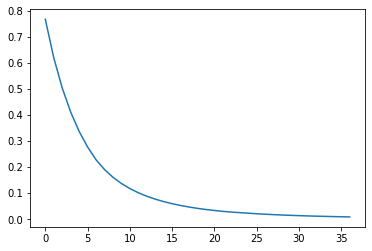

In [16]:
plt.plot(error_history)

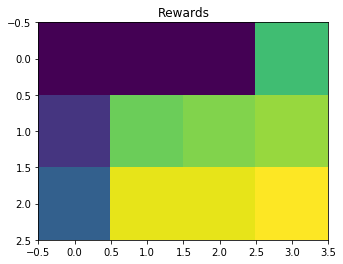

In [17]:
rewards_grid = rewards.reshape((g.length_max, g.height, g.width))
rewards_grid = rewards_grid[0,:,:]

# Map

plt.imshow(rewards_grid);
plt.title('Rewards')
plt.show()

In [18]:
rewards.reshape((g.length_max, g.height, g.width))

array([[[-1.35855875, -1.35637205, -1.35418534,  0.15856006],
        [-1.02567137,  0.33507408,  0.41326076,  0.49144743],
        [-0.692784  ,  0.74396143,  0.74614813,  0.82433481]],

       [[-1.36308677, -1.36090006, -1.35871336,  0.15403204],
        [-1.03019939,  0.33054606,  0.40873274,  0.48691941],
        [-0.69731202,  0.73943341,  0.74162011,  0.81980679]],

       [[-1.36761478, -1.36542808, -1.36324138,  0.14950402],
        [-1.03472741,  0.32601805,  0.40420472,  0.4823914 ],
        [-0.70184003,  0.73490539,  0.7370921 ,  0.81527877]],

       [[-1.3721428 , -1.3699561 , -1.36776939,  0.144976  ],
        [-1.03925543,  0.32149003,  0.3996767 ,  0.47786338],
        [-0.70636805,  0.73037738,  0.73256408,  0.81075076]],

       [[-1.37667082, -1.37448411, -1.37229741,  0.14044799],
        [-1.04378344,  0.31696201,  0.39514869,  0.47333536],
        [-0.71089607,  0.72584936,  0.72803606,  0.80622274]]])

In [19]:
def generate_demonstrations(g, policy, n_trajs=10, len_traj=5):
    """gatheres expert demonstrations
    inputs:
    policy      Nx1 matrix
    n_trajs     int - number of trajectories to generate
    rand_start  bool - randomly picking start position or not
    start_pos   2x1 list - set start position, default [0,0]
    returns:
    trajs       a list of trajectories - each element in the list is a list of Steps representing an episode
    """

    trajs = []
    for i in range(n_trajs):
        
        episode = []
        state = (0,1,1)
        idx = g.state2idx(state)
        episode.append(idx)
        
        # while not is_done:
        for _ in range(len_traj-1):

            act = np.random.choice(g.n_actions, p= policy[idx,:])
            next_state = g.get_next_state(state, act)
            next_idx = g.state2idx(next_state)
            episode.append(next_idx)
            state = next_state
            idx = next_idx
            
        trajs.append(episode)
    return trajs

In [20]:
trajs = generate_demonstrations(g, policy, 50, 5)
trajs

[[5, 17, 29, 42, 53],
 [5, 21, 34, 46, 53],
 [5, 22, 34, 46, 53],
 [5, 22, 34, 46, 53],
 [5, 18, 34, 46, 53],
 [5, 22, 35, 46, 53],
 [5, 17, 34, 46, 53],
 [5, 18, 29, 46, 53],
 [5, 22, 34, 46, 53],
 [5, 21, 33, 41, 53],
 [5, 22, 34, 46, 53],
 [5, 22, 33, 45, 53],
 [5, 22, 35, 42, 53],
 [5, 21, 33, 46, 53],
 [5, 18, 30, 45, 53],
 [5, 18, 34, 46, 53],
 [5, 21, 34, 46, 53],
 [5, 22, 34, 46, 53],
 [5, 21, 29, 46, 53],
 [5, 22, 34, 46, 53],
 [5, 22, 34, 46, 53],
 [5, 22, 33, 45, 53],
 [5, 22, 31, 46, 53],
 [5, 17, 34, 41, 53],
 [5, 22, 34, 46, 53],
 [5, 21, 33, 46, 53],
 [5, 21, 30, 45, 53],
 [5, 21, 30, 46, 53],
 [5, 22, 31, 46, 53],
 [5, 21, 33, 45, 53],
 [5, 21, 33, 45, 53],
 [5, 22, 34, 45, 53],
 [5, 18, 35, 46, 53],
 [5, 18, 27, 42, 53],
 [5, 21, 33, 42, 53],
 [5, 22, 34, 46, 53],
 [5, 18, 31, 42, 53],
 [5, 17, 33, 45, 53],
 [5, 22, 34, 46, 53],
 [5, 16, 33, 45, 53],
 [5, 18, 35, 46, 53],
 [5, 22, 34, 46, 53],
 [5, 22, 34, 46, 53],
 [5, 18, 35, 46, 53],
 [5, 22, 30, 46, 53],
 [5, 17, 3

In [21]:
freq = np.zeros((3,4))
for traj in trajs:
    for idx in traj:
        state = g.idx2state(idx)
        freq[state[1], state[2]] += 1
        
freq

array([[  0.,   0.,   0.,   1.],
       [  1., 110.,  21.,   3.],
       [  0.,  36.,  71.,   7.]])

## Deep

Deep MaxEnt Inverse reinforcement Learning - the reward function is a CNN

In [441]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader

In [442]:
feat_map = torch.tensor([[map_mask, map_dist, map_gradv, map_gradh, map_const]])

In [443]:
feat_map.shape

torch.Size([1, 5, 3, 4])

The input tensor must be of size $(N,C_{in},H,W)$ 

with 
- $N$ batch size
- $C_{in}$ number of channels
- $H$ height of the image
- $W$ width of the image

In [391]:
g.length_max

5

In [456]:
layer1 = nn.Sequential(
            nn.Conv2d(5, 5, kernel_size = 3, stride=1, padding=1))

layer2 = nn.Sequential(
            nn.Conv2d(5, 5, kernel_size = 3, stride=1, padding=1),
            nn.ReLU())

In [457]:
layer2(layer1(x)).shape

torch.Size([1, 5, 3, 4])

In [458]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(5, 5, kernel_size = 3, stride=1, padding=1))
        self.layer2 = nn.Sequential(
            nn.Conv2d(5, 5, kernel_size = 3, stride=1, padding=1),
            nn.ReLU())
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        return out
    
    def get_reward_mat(self, x):
        out = self.forward(x)
        rewards = out.detach().numpy()
        return -rewards[0].reshape((60,1))
        

In [459]:
model = ConvNet()
model.get_reward_mat(feat_map)

array([[-2.73765802e-01],
       [-3.73256505e-01],
       [-2.60760218e-01],
       [-1.43410683e-01],
       [-4.21943843e-01],
       [-3.82943034e-01],
       [-1.02125406e-01],
       [-1.30047098e-01],
       [-0.00000000e+00],
       [-6.01871386e-02],
       [-0.00000000e+00],
       [-4.66974303e-02],
       [-0.00000000e+00],
       [-0.00000000e+00],
       [-0.00000000e+00],
       [-0.00000000e+00],
       [-1.40328854e-01],
       [-1.05537176e-02],
       [-0.00000000e+00],
       [-0.00000000e+00],
       [-0.00000000e+00],
       [-0.00000000e+00],
       [-0.00000000e+00],
       [-0.00000000e+00],
       [-0.00000000e+00],
       [-1.78463280e-01],
       [-8.74055475e-02],
       [-9.39313546e-02],
       [-0.00000000e+00],
       [-0.00000000e+00],
       [-0.00000000e+00],
       [-6.07213490e-02],
       [-1.25839174e-01],
       [-3.45807080e-03],
       [-0.00000000e+00],
       [-3.72879095e-02],
       [-0.00000000e+00],
       [-6.28970191e-02],
       [-0.0

In [460]:
def demo_svf(trajs, n_states):
    """
    compute state visitation frequences from demonstrations

    input:
    trajs   list of list of Steps - collected from expert
    returns:
    p       Nx1 vector - state visitation frequences   
    """

    p = np.zeros(n_states)
    for traj in trajs:
        for step in traj:
            p[step] += 1
    p = p/len(trajs)
    return p

In [461]:
model = ConvNet()
mu_D = demo_svf(trajs, P.shape[0])

# Run the forward pass
rewards = model.get_reward_mat(feat_map)

# compute policy 
_, policy = value_iteration(P, rewards, error=0.01, max_iter=100)

# compute expected svf
mu_exp = compute_state_visition_freq(P, g.state2idx((0,1,1)), g.length_max, policy)
    

In [462]:
# compute gradients on rewards:
grad_r = mu_D - mu_exp

In [463]:
torch.tensor(grad_r)

tensor([ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  2.8655e-02,  1.6064e-02, -8.2500e-02,
         0.0000e+00,  2.9507e-02,  4.9306e-02, -4.2688e-02,  0.0000e+00,
        -1.1153e-01,  5.5877e-02,  5.7312e-02,  0.0000e+00, -1.2794e-01,
        -1.2783e-01, -2.0774e-02, -1.8230e-02, -1.1955e-01,  3.0555e-01,
         3.1480e-02, -7.0184e-03, -1.2823e-01,  2.1183e-01, -7.7016e-04,
         1.4822e-03, -6.0445e-02, -2.1109e-02, -1.0999e-02,  0.0000e+00,
        -7.4506e-02,  2.5242e-02,  4.2648e-02,  0.0000e+00, -9.1032e-02,
         1.4115e-01,  4.9052e-02,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00, -2.2204e-16,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
       dtype=torch.float64)

In [464]:
opt = torch.optim.Adam(model.parameters(), lr=0.05)

In [465]:
# apply gradients to the neural network
opt.zero_grad()
torch.autograd.backward([model(feat_map)], [torch.tensor(grad_r.reshape((1,5,3,4)))]) 
opt.step()
rewards = model.get_reward_mat(feat_map)
print(rewards)

[[-1.89303905e-01]
 [-5.14828682e-01]
 [-3.11649352e-01]
 [-1.57838061e-01]
 [-2.55378038e-01]
 [-6.26967669e-01]
 [-4.08533275e-01]
 [-1.41879320e-01]
 [-6.50388300e-02]
 [-1.74619257e-01]
 [-5.99824823e-02]
 [-1.96984205e-02]
 [-0.00000000e+00]
 [-0.00000000e+00]
 [-0.00000000e+00]
 [-0.00000000e+00]
 [-0.00000000e+00]
 [-0.00000000e+00]
 [-0.00000000e+00]
 [-0.00000000e+00]
 [-0.00000000e+00]
 [-0.00000000e+00]
 [-0.00000000e+00]
 [-0.00000000e+00]
 [-8.16344917e-02]
 [-0.00000000e+00]
 [-0.00000000e+00]
 [-4.19364456e-04]
 [-8.05720627e-01]
 [-2.34009549e-01]
 [-4.60737914e-01]
 [-2.31414214e-01]
 [-5.54287434e-01]
 [-2.03869998e-01]
 [-2.68962681e-01]
 [-1.32846013e-01]
 [-3.42594743e-01]
 [-2.40729041e-02]
 [-0.00000000e+00]
 [-0.00000000e+00]
 [-5.82783163e-01]
 [-2.34720826e-01]
 [-1.85661241e-01]
 [-1.09472334e-01]
 [-1.41268283e-01]
 [-0.00000000e+00]
 [-8.38323776e-03]
 [-0.00000000e+00]
 [-0.00000000e+00]
 [-1.70762893e-02]
 [-0.00000000e+00]
 [-0.00000000e+00]
 [-1.3665102

In [466]:
def deep_maxent_irl(feat_map, P_a, trajs, lr, n_iters):
    """
    Maximum Entropy Inverse Reinforcement Learning (Maxent IRL)
    inputs:
    feat_map    NxD matrix - the features for each state
    P_a         NxNxN_ACTIONS matrix - P_a[s0, s1, a] is the transition prob of 
                                   landing at state s1 when taking action 
                                   a at state s0
    gamma       float - RL discount factor
    trajs       a list of demonstrations
    lr          float - learning rate
    n_iters     int - number of optimization steps
    returns
    rewards     Nx1 vector - recoverred state rewards
    """

    # tf.set_random_seed(1)

    N_STATES, _, N_ACTIONS = np.shape(P_a)

    # init nn model
    model = ConvNet()
    mu_D = demo_svf(trajs, P.shape[0])

    opt = torch.optim.Adam(model.parameters(), lr=0.05)
    

    error_history = []
    
    # training 
    for iteration in range(n_iters):
        if iteration % (n_iters/10) == 0:
            print('iteration: {}'.format(iteration))

        # compute the reward matrix
        rewards = model.get_reward_mat(feat_map)

        # compute policy 
        _, policy = value_iteration(P_a, rewards, error=0.01, max_iter=100)

        # compute expected svf
        mu_exp = compute_state_visition_freq(P_a, g.state2idx((0,1,1)), g.length_max, policy)

        # compute gradients on rewards:
        grad_r = mu_D - mu_exp

        error_history.append(sum(grad_r**2)) 
        
        plt.plot(error_history)
        IPython.display.clear_output(wait=True)
        IPython.display.display(plt.show())

            
        # apply gradients to the neural network
        opt.zero_grad()
        torch.autograd.backward([model(feat_map)], [torch.tensor(grad_r.reshape((1,5,3,4)))]) 
        opt.step()


    rewards = model.get_reward_mat(feat_map)
        
    return rewards, policy

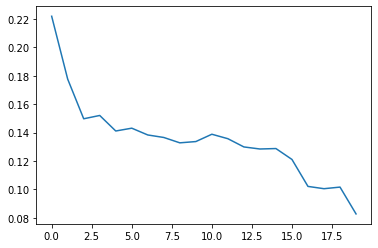

None

In [492]:
rewards,policy = deep_maxent_irl(feat_map, P, trajs, 0.1, 20)

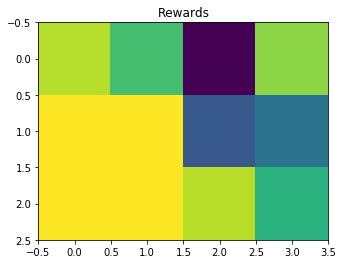

array([[-0.07499631, -0.1967707 , -0.66800904, -0.11738005],
       [-0.        , -0.        , -0.48121646, -0.4125611 ],
       [-0.        , -0.        , -0.07293803, -0.24021767]],
      dtype=float32)

In [493]:
rewards_grid = rewards.reshape((g.length_max, g.height, g.width))
rewards_grid = rewards_grid[0,:,:]

# Map

plt.imshow(rewards_grid);
plt.title('Rewards')
plt.show()

rewards_grid

In [494]:
trajs = generate_demonstrations(g, policy, 50, 5)
trajs

[[5, 21, 33, 45, 53],
 [5, 14, 30, 37, 53],
 [5, 17, 33, 46, 53],
 [5, 17, 34, 46, 53],
 [5, 21, 33, 42, 53],
 [5, 18, 27, 42, 53],
 [5, 13, 25, 37, 53],
 [5, 18, 30, 37, 53],
 [5, 21, 30, 46, 53],
 [5, 17, 33, 45, 53],
 [5, 22, 34, 46, 53],
 [5, 18, 33, 46, 53],
 [5, 16, 33, 40, 53],
 [5, 14, 27, 42, 53],
 [5, 14, 29, 41, 53],
 [5, 20, 33, 44, 53],
 [5, 14, 31, 46, 53],
 [5, 16, 33, 40, 53],
 [5, 18, 35, 42, 53],
 [5, 20, 29, 40, 53],
 [5, 20, 32, 44, 53],
 [5, 21, 30, 45, 53],
 [5, 14, 26, 38, 53],
 [5, 17, 30, 38, 53],
 [5, 18, 26, 38, 53],
 [5, 13, 25, 37, 53],
 [5, 14, 30, 46, 53],
 [5, 21, 34, 46, 53],
 [5, 14, 26, 38, 53],
 [5, 14, 26, 42, 53],
 [5, 14, 26, 41, 53],
 [5, 20, 33, 46, 53],
 [5, 16, 25, 40, 53],
 [5, 22, 34, 46, 53],
 [5, 22, 34, 46, 53],
 [5, 18, 34, 41, 53],
 [5, 18, 33, 42, 53],
 [5, 22, 34, 46, 53],
 [5, 18, 26, 38, 53],
 [5, 18, 29, 38, 53],
 [5, 17, 34, 45, 53],
 [5, 12, 25, 40, 53],
 [5, 20, 33, 45, 53],
 [5, 14, 26, 38, 53],
 [5, 21, 33, 45, 53],
 [5, 21, 3

In [495]:
freq = np.zeros((3,4))
for traj in trajs:
    for idx in traj:
        state = g.idx2state(idx)
        freq[state[1], state[2]] += 1
        
freq

array([[  1.,  10.,  24.,   2.],
       [  8., 113.,  25.,   2.],
       [  8.,  30.,  26.,   1.]])